In [1]:
import os
import sys
sys.path.append('/home/ubuntu/project')
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import numpy as np
import cv2
import torch

from facenet_pytorch import MTCNN
from detectors import DSFD
from InsightFace.model import Backbone
from InsightFace.mtcnn_pytorch.src.align_trans import warp_and_crop_face, get_reference_facial_points
from IPython.display import display
from torchvision import transforms as trans
from PIL import Image


test_transform = trans.Compose([
                    trans.ToTensor(),
                    trans.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

reference = get_reference_facial_points(default_square= True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#detection = DSFD(device='cuda', PATH_WEIGHT = '../detectors/dsfd/weights/dsfd_vgg_0.880.pth')

mtcnn = MTCNN()

model = Backbone(50, 0.6, 'ir_se').to('cuda')

model.load_state_dict(torch.load('/home/ubuntu/project/InsightFace/weights/ir_50se.pth'))
model.eval()

hortcut_layer): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
      (res_layer): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): PReLU(num_parameters=64)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): SEModule(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (relu): ReLU(inplace)
          (fc2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (sigmoid): Sigmoid()
        )
      )
    )
    (3): bottleneck_IR_SE(
      (shortcut_layer): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1):

In [2]:
def detect_align_face(img):
    boxes, _, landmarks = mtcnn.detect(img, landmarks=True)

    faces = []
    for landmark in landmarks:
        face = warp_and_crop_face(img, landmark, reference, crop_size=(112,112))
        faces.append(face)

    return boxes, faces 

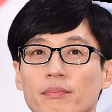

In [3]:
base = '../tmp/base.jpg'

baseimg = cv2.imread(base)
baseimg = cv2.cvtColor(baseimg, cv2.COLOR_BGR2RGB)
_, faces = detect_align_face(baseimg)

face = faces[0]

display(Image.fromarray(face))

base = model(test_transform(face).to('cuda').unsqueeze(0))

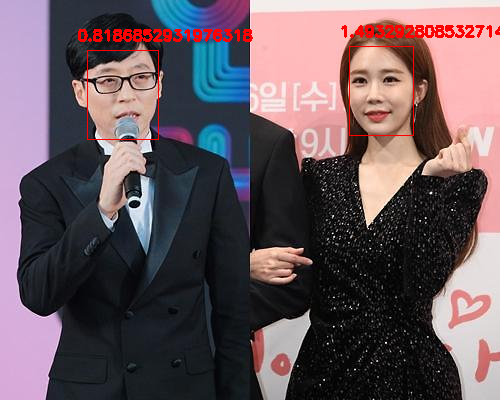

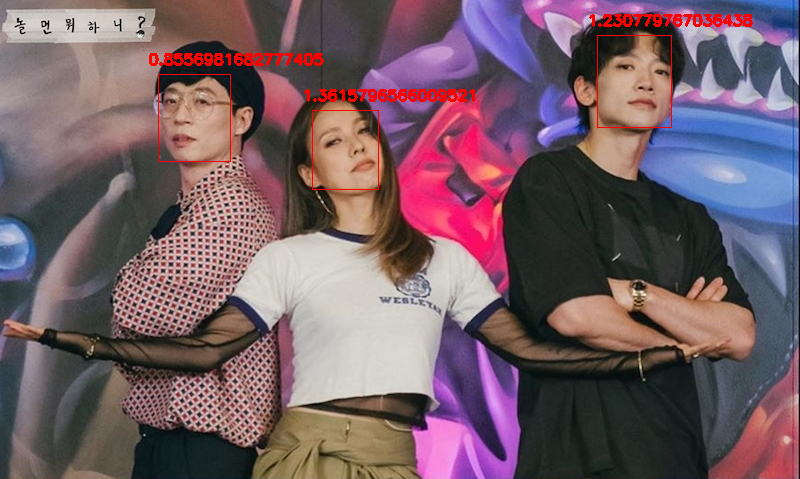

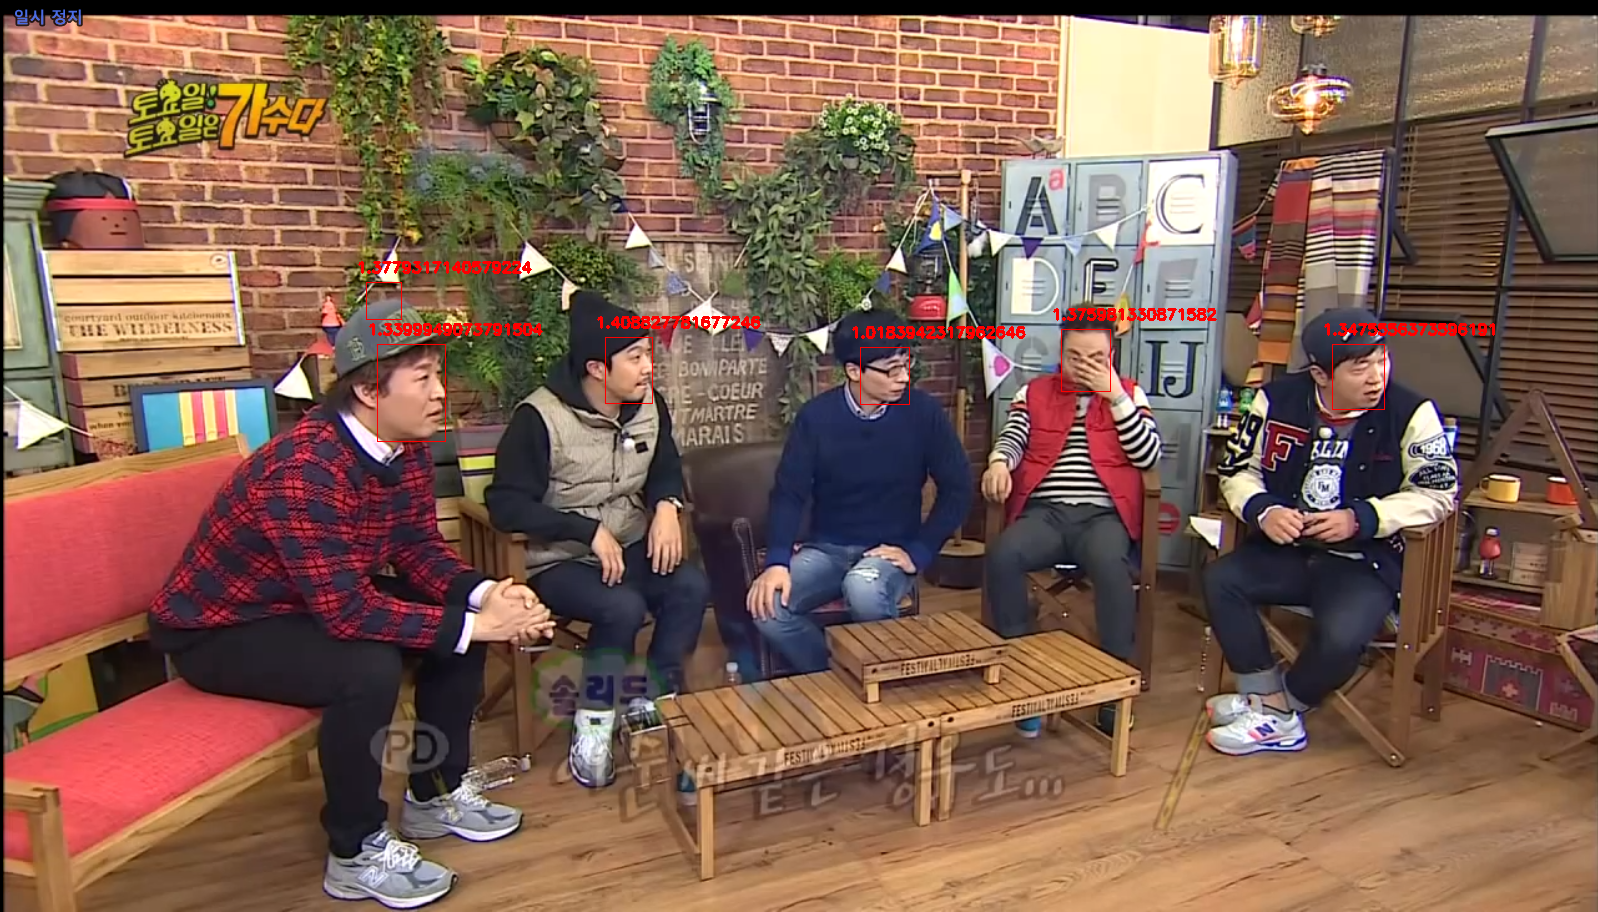

In [4]:
img_paths = ['../tmp/two.jpg', '../tmp/three.jpg', '../tmp/small.png']

rgb = (255, 0, 0)

for path in img_paths:

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    boxes, faces = detect_align_face(img)

    img_processed = img.copy()
    for box, face in zip(boxes, faces):

        x1 = int(box[0])
        y1 = int(box[1])
        x2 = int(box[2])
        y2 = int(box[3])

        img_cropped = test_transform(face).to('cuda').unsqueeze(0)

        with torch.no_grad():
            embed = model(img_cropped)

        diff = (base - embed).norm().item()

        img_processed = cv2.putText(img_processed, str(diff), (x1 - 10, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX,0.5, rgb, 2)
        img_processed = cv2.rectangle(img_processed, (x1, y1), (x2, y2), rgb, 1)

    display(Image.fromarray(img_processed))

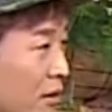

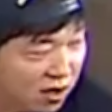

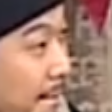

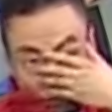

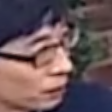

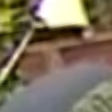

In [6]:
img = '../tmp/small.png'

img = cv2.imread(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
_, faces = detect_align_face(img)

for face in faces:
    display(Image.fromarray(face))